In [1]:
from __future__ import print_function
%matplotlib inline
import copy
import pandas as pd
import numpy as np
import librosa
import seaborn as sb
import matplotlib.pyplot as plt
import itertools
import re
import random
import gc
from os import listdir
from os.path import isfile, join
from numpy import median, diff
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

Using Theano backend.


In [2]:
# start with each input secion maps to one note
# train model for that (just list comprhension on noets for contains 1 maps to true)

# then move to bars eg section of 4 bars maps to output for each note
# error = probability of note being true vs was it really

# try bar + prev notes (home use weird dimensioned data?) to predict next notes

# try feeding in non structured data (bpm, position of time in song, song length, 
# things about feel of song (generated features))
# try using keras merge layer to add extra features

In [24]:
samples_back_included = 24
num_classes = 5
num_features = 40 + 2 + num_classes

def get_features_for_index(beat_features, notes, index):
    if index < 0:
        return [0] * num_features
    features = beat_features[index]
    misc_features = get_steps_for_index(notes, index - 1)
    misc_features.append(index % 48)
    misc_features.append(index / 48)
    return np.concatenate((features, misc_features))

def get_steps_for_index(notes, index):
    if index < 0:
        return [True, False, False, False, False]
    row = notes[index][0]
    steps = row.count('1')
    mines = row.count('M')
    
    features = [int(feature) for feature in [steps == 0 and mines == 0, steps == 1, steps == 2, steps >= 3, steps == 0 and mines > 0]]
    if sum(features) != 1:
        print ('Error')
        print (steps)
        print (mines)
    return [int(feature) for feature in [steps == 0 and mines == 0, steps == 1, steps == 2, steps >= 3, mines > 0 and steps == 0]]

def build_batch_generator():
    songs_to_use = pd.read_csv('data/songs_to_use.csv').values
    save_files = listdir('data')
    for song_data in songs_to_use:
        if '{0}_beat_features.csv'.format(song_data[0]) in save_files and '{0}_notes.csv'.format(song_data[0]) in save_files:
            X = []
            y = []
            beat_features_rotated = pd.read_csv('data/{0}_beat_features.csv'.format(song_data[0])).values
            notes = pd.read_csv('data/{0}_notes.csv'.format(song_data[0]), converters={'0': lambda x: str(x)}).values
            beat_features = np.flipud(np.rot90(np.array(beat_features_rotated)))
            for i in range(min(len(notes), len(beat_features))):
                features = [feature for j in range(samples_back_included) for feature in get_features_for_index(beat_features, notes, i - j)]
                X.append(features)
                y.append(get_steps_for_index(notes, i))
            yield (np.array(X), np.array(y))

def build_training_data(num_songs_to_use):
    X = []
    y = []
    songs_to_use = pd.read_csv('data/songs_to_use.csv').values
    save_files = listdir('data')
    for song_data in songs_to_use[:num_songs_to_use]:
        if '{0}_beat_features.csv'.format(song_data[0]) in save_files and '{0}_notes.csv'.format(song_data[0]) in save_files:
            beat_features_rotated = pd.read_csv('data/{0}_beat_features.csv'.format(song_data[0])).values
            notes = pd.read_csv('data/{0}_notes.csv'.format(song_data[0]), converters={'0': lambda x: str(x)}).values
            beat_features = np.flipud(np.rot90(np.array(beat_features_rotated)))
            for i in range(min(len(notes), len(beat_features))):
                row_y = get_steps_for_index(notes, i)
                if not (row_y[0] == 1 and random.randint(0, 70) != 0) and not (row_y[1] == 1 and random.randint(0, 10) != 0):
                    features = [feature for j in range(samples_back_included) for feature in get_features_for_index(beat_features, notes, i - j)]
                    X.append(features)
                    y.append(row_y)
    return X, y

In [28]:
X, y = build_training_data(100)

In [29]:
[sum(row[i] for row in y) for i in range(num_classes)]

[3500, 2956, 2485, 14, 715]

In [6]:
X_filtered = []
y_filtered = []
class_0_count = 0
for index in range(len(X)):
    if not (y[index][0] == 1 and index % 49 != 0) and not (y[index][1] == 1 and index % 7 != 0):
        X_filtered.append(X[index])
        y_filtered.append(y[index])

In [7]:
[sum(row[i] for row in y_filtered) for i in range(num_classes)]

[5129, 4749, 2485, 14, 715]

In [31]:
clf_rf = RandomForestClassifier(n_estimators=20)
clf_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
gen = build_batch_generator()
X2, y2 = next(gen)
new_y = clf_rf.predict(X)

Length: 9670


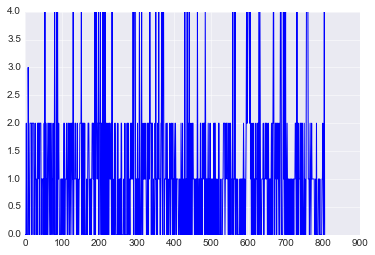

In [34]:
def get_max(row):
    return np.array(row).argmax()

weights = [1, 3, 15, 20, 15]
def get_max_alt(row):
    return np.array([weights[i] * row[i] for i in range(num_classes)]).argmax()
    
print ('Length: ' + str(len(new_y)))
filtered = [new_y[i] for i in range(len(new_y)) if i % 12 == 0]
most_likely = [get_max(row) for row in filtered]
sb.set_style("darkgrid")
plt.plot(most_likely)
plt.show()

# Categories =
- no_notes
- one_note
- two_notes
- many_notes
- mine

In [209]:
beat_feature_model = Sequential()
beat_feature_model.add(Dense(500, input_dim=samples_back_included * num_features, init='uniform', activation='tanh'))
beat_feature_model.add(Dense(200, activation='tanh'))
beat_feature_model.add(Dense(50, activation='tanh'))
beat_feature_model.add(Dense(num_classes, activation='softmax'))

beat_feature_model.compile(loss='categorical_crossentropy',
                           optimizer='adadelta',
                           metrics=['accuracy'])

In [210]:
class_weight={0:1, 1:2., 2:4., 3:8., 4:16.}
gen = build_batch_generator()
#beat_feature_model.fit(X[:1000], y[:1000], nb_epoch=10, batch_size=32)
#for data in gen:
for i in range(20):
    data = next(gen)
    X, y = data
    beat_feature_model.train_on_batch(X, y, class_weight=class_weight)

gen = build_batch_generator()
for i in range(3):
    X, y = next(gen)
    print (beat_feature_model.test_on_batch(X, y))

[array(0.5019330978393555, dtype=float32), array(0.8501602411270142, dtype=float32)]
[array(0.4018665850162506, dtype=float32), array(0.9275362491607666, dtype=float32)]
[array(0.5231761932373047, dtype=float32), array(0.8848039507865906, dtype=float32)]


In [212]:
X, y = next(gen)
predictions = beat_feature_model.predict(X)
[predictions[i] for i in range(len(predictions)) if i % 12 == 0]

[array([ 0.57776904,  0.284493  ,  0.02801899,  0.05478921,  0.05492973], dtype=float32),
 array([ 0.86535132,  0.08644518,  0.02160909,  0.01942644,  0.00716798], dtype=float32),
 array([ 0.75991422,  0.19061624,  0.03410141,  0.00631623,  0.0090519 ], dtype=float32),
 array([ 0.82155448,  0.14643079,  0.02075813,  0.00423729,  0.00701931], dtype=float32),
 array([ 0.80458021,  0.14407434,  0.03336709,  0.00545411,  0.01252428], dtype=float32),
 array([ 0.76010001,  0.20040545,  0.02226696,  0.00469081,  0.01253674], dtype=float32),
 array([ 0.78770775,  0.17597443,  0.02186031,  0.00612088,  0.00833664], dtype=float32),
 array([ 0.78554082,  0.18543176,  0.01693058,  0.00557171,  0.00652514], dtype=float32),
 array([ 0.78773308,  0.17198847,  0.02562498,  0.00510776,  0.00954572], dtype=float32),
 array([ 0.7753759 ,  0.16128875,  0.04599478,  0.00522301,  0.01211754], dtype=float32),
 array([ 0.70473021,  0.24011187,  0.03892151,  0.00731906,  0.00891738], dtype=float32),
 array([ 0